In [1]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

import glob
import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
annotations = pd.read_csv('data/train_solution_bounding_boxes (1).csv')

In [3]:
annotations.shape

(559, 5)

In [4]:
annotations = annotations.assign(class_name = 'car')

In [5]:
annotations['height'] = round(annotations['ymax'] - annotations['ymin']).astype(int)
annotations['width'] = round(annotations['xmax'] - annotations['xmin']).astype(int)
annotations.rename(columns={'xmin': 'x_min', 'ymin': 'y_min', 'xmax': 'x_max', 'ymax': 'y_max'}, inplace=True)

In [6]:
annotations['x_min'] = annotations['x_min'].apply(lambda x: int(str(round(x)).split('.')[0]))
annotations['y_min'] = annotations['y_min'].apply(lambda x: int(str(round(x)).split('.')[0]))
annotations['x_max'] = annotations['x_max'].apply(lambda x: int(str(round(x)).split('.')[0]))
annotations['y_max'] = annotations['y_max'].apply(lambda x: int(str(round(x)).split('.')[0]))

In [7]:
annotations.head()

,image,x_min,y_min,x_max,y_max,class_name,height,width
0,vid_4_1000.jpg,281,187,328,223,car,36,46
1,vid_4_10000.jpg,15,187,120,236,car,49,105
2,vid_4_10040.jpg,239,177,362,236,car,60,123
3,vid_4_10020.jpg,496,172,630,232,car,59,134
4,vid_4_10060.jpg,17,187,133,238,car,52,116


In [8]:
annotations.image.unique().shape[0], annotations.shape[0]

(355, 559)

In [9]:
def annotate_image(annotations, resize=True):
  file_name = annotations.image.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'data/training_images/{file_name}'), cv2.COLOR_BGR2RGB)
  for i, a in annotations.iterrows():
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation=cv2.INTER_AREA)

(-0.5, 675.5, 379.5, -0.5)

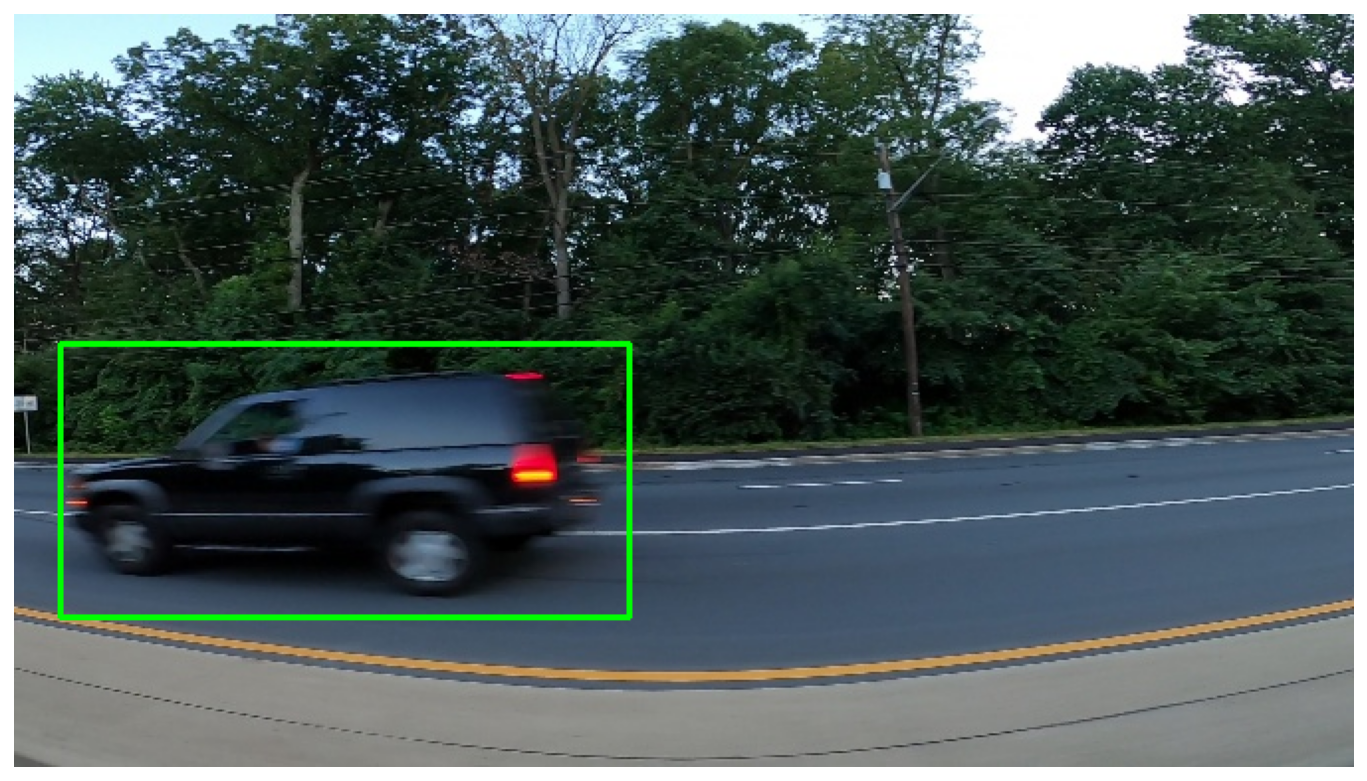

In [10]:
img_df = annotations[annotations.image == annotations.image.unique()[50]]
img = annotate_image(img_df, resize=False)
plt.imshow(img)
plt.axis('off')

In [11]:
train_files = os.listdir('data/training_images/')

In [12]:
unique_files = annotations.image.unique()
train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = annotations[annotations.image.isin(train_files)]
test_df = annotations[~annotations.image.isin(train_files)]

In [13]:
annotations.shape, train_df.shape, test_df.shape

((559, 8), (535, 8), (24, 8))

In [14]:
annotations.head()

,image,x_min,y_min,x_max,y_max,class_name,height,width
0,vid_4_1000.jpg,281,187,328,223,car,36,46
1,vid_4_10000.jpg,15,187,120,236,car,49,105
2,vid_4_10040.jpg,239,177,362,236,car,60,123
3,vid_4_10020.jpg,496,172,630,232,car,59,134
4,vid_4_10060.jpg,17,187,133,238,car,52,116


In [15]:
IMAGES_PATH = f'data/training_images'
classes = annotations.class_name.unique().tolist()

def create_dataset_dicts(df, classes):
  dataset_dicts = []

  for image_id, img_name in enumerate(df.image.unique()):
    record = {}
    image_df = df[df.image == img_name]
    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = cv2.imread(file_path).shape[0]
    record["width"] = cv2.imread(file_path).shape[1]
    
    
    objs = []
    for _, row in image_df.iterrows():
      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)
      poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))
      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)

  return dataset_dicts

In [16]:
dd = create_dataset_dicts(train_df, classes)

In [17]:
dd['file_name' == 'data/training_images/vid_4_9460.jpg']

{'file_name': 'data/training_images/vid_4_1000.jpg',
 'image_id': 0,
 'height': 380,
 'width': 676,
 'annotations': [{'bbox': [281, 187, 328, 223],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[281, 187, 328, 187, 328, 223, 281, 223]],
   'category_id': 0,
   'iscrowd': 0}]}

In [18]:
for d in ["train", "val"]:
  DatasetCatalog.register("cars_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("cars_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("cars_train")

In [19]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [20]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)

In [21]:
cfg.DATASETS.TRAIN = ("cars_train",)
cfg.DATASETS.TEST = ("cars_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.OPTIMIZER = 'AdamW'

In [22]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500

In [23]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/17 12:08:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[01/17 12:08:32 d2.engine.train_loop]: Starting training from iteration 0


/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [01/17 12:08:34 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/detectron2/engine/train_loop.py", line 286, in run_step
    losses.backward()
  File "/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/torch/autograd/__init__.py", line 197, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 252.00 MiB (GPU 0; 3.82 GiB tota

OutOfMemoryError: CUDA out of memory. Tried to allocate 252.00 MiB (GPU 0; 3.82 GiB total capacity; 3.54 GiB already allocated; 15.25 MiB free; 3.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
annotations[annotations.image == 'vid_4_9460.jpg']

,image,x_min,y_min,x_max,y_max,class_name,height,width
519,vid_4_9460.jpg,0,189,60,225,car,36,60


In [29]:
a = cv2.imread('data/training_images/vid_4_9460.jpg')

In [30]:
a.shape

(380, 676, 3)

In [25]:
for i in dd:
    if i['file_name'] == 'data/training_images/vid_4_9460.jpg':
        print(i)

{'file_name': 'data/training_images/vid_4_9460.jpg', 'image_id': 314, 'height': 1, 'width': 8, 'annotations': [{'bbox': [0, 189, 60, 225], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[0, 189, 60, 189, 60, 225, 0, 225]], 'category_id': 0, 'iscrowd': 0}]}
